# Computing reflectance and transmittance with PyMoosh

## The simple way

We wish to compute the reflection (r) and transmission (t) coefficients of a multilayer stack (and the reflectance/transmittance along the way). 

For this, we need to define the structure we are studying, within the ```Structure``` class. For a detailed explanation, see the "Readme first" notebook.

In [1]:
from PyMoosh import *

material_list = [1.,1.5**2,"Water"]
stack = [0,2,1,0]
thickness=[0,500,500,0]

multilayer = Structure(material_list,stack,thickness)

List of materials:
Simple, non dispersive: epsilon= 1.0
Simple, non dispersive: epsilon= 2.25
Database material: Water, model: Exp Data


This ```Structure``` object contains most of the information to compute the reflection/transmission coefficients. We also need to tell it a bit more about the incident field.

In [3]:
# Incidence angle
angle_inc=0.
# Polarization
pol=1.
# Wavelength
wavelength = 2.5

Now we have everything, and the coefficients can be computed with the following line:

In [5]:
r, t, R, T = coefficient(multilayer,wavelength,angle_inc,pol)

print(f"Reflection coefficient: {r}, Reflectance coefficient: {R}")
print(f"Transmission coefficient: {t}, Transmittance coefficient: {T}")

Reflection coefficient: (0.2871562826313957-5.364312255102922e-14j), Reflectance coefficient: 0.08245873065468201
Transmission coefficient: (-1.4305194625664586e-13-0.9578837452140622j), Transmittance coefficient: 0.9175412693453184


Now this is the simplest way to compute these coefficients, and it might be enough for your needs. But you can have more control if you want, by choosing how these coefficients are computed.

## The different formalisms

PyMoosh implements 4 different ways to compute the reflection/transmission coefficients, and one more that can only compute the reflection coefficients. They each correspond to a different formalism but give the same result (in most cases).

These formalisms are:

- T Matrix formalism
- Abeles Matrix formalism
- S Matrix formalism
- Dirichlet-to-Neumann formalism
- Impedance (or admittance) formalism, which computes only reflection coefficients

Now they are all based on the same principle:

1. Choose physical quantities linked to the electromagnetic field propagating in the structure (typically \$E\$ and \$H\$, or \$E\$ and \$\partial E\$),
2. (Optional) Divide these quantities between upward propagating and downward propagation in the multilayer stack,
3. Write continuity conditions at the interface between two layers of the stack,
4. Deduce a recursive relation between your physical quantities,
5. Compute the link between the up-most and down-most field quantities,
6. Use these to compute the reflection and transmission coefficients

How you do steps 1. and 2. defines which of the 5 main methods you are using, and influences both the speed and the numerical stability of the results.

### Example with T Matrix formalism

Physical quantities are the \$E_i\$ fields in each layer, decomposed first between the upward field \$A_i\$ and the downward field \$B_i\$. On top of this, they are split between the field at the top of the layer \$A_i^+\$, \$B_i^+\$ and at the bottom of the layer \$A_i^-\$, \$B_i^-\$.

The goal is then to find a way to link these fields through a relation of the following sort:

\$\begin{pmatrix}A_{i+1}^{+} \\ B_{i+1}^{+}\end{pmatrix} = M_{i, i+1} \begin{pmatrix}A_{i}^{+} \\ B_{i}^{+}\end{pmatrix}\$,
where \$M_{i, i+1}\$ is a 2x2 matrix that can be computed using the physical properties of the multilayer.

It happens that this can be done using continuity relations at each interface and propagation properties within the layers, such that:

\$\begin{pmatrix}A_{i+1}^{+} \\ B_{i+1}^{+}\end{pmatrix} = T_{i, i+1} \begin{pmatrix}A_{i}^{-} \\ B_{i}^{-}\end{pmatrix}\$, and \$\begin{pmatrix}A_{i}^{-} \\ B_{i}^{-}\end{pmatrix} = C_{i} \begin{pmatrix}A_{i}^{+} \\ B_{i}^{+}\end{pmatrix}\$.

So that \$\begin{pmatrix}A_{i}^{+} \\ B_{i}^{+}\end{pmatrix} = \prod \left( T_{i, i+1} C_{i} \right)  \begin{pmatrix}A_{0}^{+} \\ B_{0}^{+}\end{pmatrix}\$.

Computing the \$T\$ and \$C\$ matrices, and computing their product, leads to the whole transfer matrix of the structure, \$M = \begin{pmatrix} M_{11} & M_{12} \\ M_{21} & M_{22}\end{pmatrix}\$ such that:

\$ \begin{pmatrix}A_{N}^{+} \\ B_{N}^{+}\end{pmatrix} = M \begin{pmatrix}A_{0}^{+} \\ B_{0}^{+}\end{pmatrix} \$,

where \$B_{0}^{+}\$ is the incoming field, for instance, and thus \$A_{0}^{+}\$ is the reflection coefficient r, which can be computed as \$r = -\frac{M_{21}}{M_{11}} \$.

### Summary of differences

As said above, all formalisms are based on a similar approach. The difference is how they treat the different quantities:

#### S Matrix
The S Matrix formalism uses the same \$A_i^-\$, \$B_i^-\$, \$A_i^+\$, \$B_i^+\$ as the T matrix formalism, but rather than linking the field on one side of the interface (\$A_{i+1}^{+}, B_{i+1}^{+}\$) to the field on the other side of the interface (\$A_{i}^{-}, B_{i}^{-}\$), it links the fields going towards the interface (\$A_{i}^{+}, B_{i+1}^{-}\$) and the field going away from the interface (\$A_{i+1}^{+}, B_{i}^{-}\$).

This makes the link between layers significantly less trivial, as instead of \$\begin{pmatrix}A_{i+1}^{+} \\ B_{i+1}^{+}\end{pmatrix} = T_{i, i+1} \begin{pmatrix}A_{i}^{-} \\ B_{i}^{-}\end{pmatrix}\$ and \$\begin{pmatrix}A_{i}^{+} \\ B_{i}^{+}\end{pmatrix} = T_{i-1, i} \begin{pmatrix}A_{i-1}^{-} \\ B_{i-1}^{-}\end{pmatrix}\$ you now have:

\$\begin{pmatrix}A_{i}^{-} \\ B_{i+1}^{+}\end{pmatrix} = S_{i, i+1} \begin{pmatrix}B_{i}^{-} \\ A_{i+1}^{+}\end{pmatrix}\$ and \$\begin{pmatrix}A_{i-1}^{-} \\ B_{i}^{+}\end{pmatrix} = S_{i-1, i} \begin{pmatrix}B_{i-1}^{-} \\ A_{i}^{+}\end{pmatrix}\$, meaning a simple matrix product is no longer possible.

On the other hand, this method is consistently more stable than the T-matrix method (and all other methods as well).

#### Abeles and Dirichlet-to-Neumann
The Abeles and Dirichlet-to-Neumann formalisms both use \$E\$ and \$\partial E\$ rather than only \$E\$. This is similar to taking into account both the \$E\$ and \$H\$ fields throughout the whole structure.

Then, in analogy to the T and S matrix, the Abeles formalism links the fields of one layer to the fields in the next, like the T matrix, meaning we can use simple matrix products to make the complete computation. On the other hand, the Dirichlet-to-Neumann formalism, like the S matrix, links the ingoing fields at an interface to the outgoing fields, making the computations harder but the overall method numerically more stable.

#### Admittance formalism

The admittance formalism is a simplification of the Abeles formalism.

Because it uses both the \$E\$ and \$H\$ fields, we can always define the admittance of the layers as \$Y_i = \frac{H_i}{E_i}\$. Then the link between the admittance of two different layers can be extracted from the Abeles formalism, effectively reducing the matrix product to a single computation.

Now, let us verify these methods are equivalent:

In [6]:
import numpy as np

#materials = [1.513**2, 1.455**2, 2.079**2, (1.9+4.8j)**2, 1.0003**2]
materials = [4., 1.5**2, 2.+1.j]
wav = 45.2


print("Intermediate incidence:")
incidence = 15*np.pi/180
prob = False

## Case 1: single layer, TE
#structure = np.random.random(nb_couches*2+1)*w_mean
structure = np.array([1])

# stack = [0]+[1,2]*nb_couches+[1,0]
stack = [0,2,0]


epaisseurs = np.concatenate(([0],structure,[0]))

chose = Structure(materials,stack,epaisseurs, verbose=False)
r, t, R, T = coefficient_S(chose,wav,incidence,0)

r_ab, t_ab, R_ab, T_ab = coefficient_A(chose,wav,incidence,0)

r_t, t_t, R_t, T_t = coefficient_T(chose,wav,incidence,0)

r_dn, t_dn, R_dn, T_dn = coefficient_DN(chose,wav,incidence,0)

r_i, R_i = coefficient_I(chose,wav,incidence,0)
print(f"single interface and abeles coeff refl in TE error = {np.format_float_scientific(abs(abs(r-r_ab)/r), 2)}")


print(f"single interface and TMatrix coeff refl in TE error = {np.format_float_scientific(abs(abs(r-r_t)/r), 2)}")


print(f"single interface and Dirichlet_to_Neumann coeff refl in TE error = {np.format_float_scientific(abs(abs(r-r_dn)/r), 2)}")


print(f"single interface and Impedance coeff refl in TE error = {np.format_float_scientific(abs(abs(r-r_i)/r), 2)}")


print(f"single interface and abeles coeff trans in TE error = {np.format_float_scientific(abs(abs(t-t_ab)/t), 2)}")


print(f"single interface and TMatrix coeff trans in TE error = {np.format_float_scientific(abs(abs(t-t_t)/t), 2)}")


print(f"single interface and Dirichlet_to_Neumann coeff trans in TE error = {np.format_float_scientific(abs(abs(t-t_dn)/t), 2)}")

print()


## Case 2: single layer, TM
#structure = np.random.random(nb_couches*2+1)*w_mean
structure = np.array([1])

# stack = [0]+[1,2]*nb_couches+[1,0]
stack = [0,2,0]


epaisseurs = np.concatenate(([0],structure,[0]))

chose = Structure(materials,stack,epaisseurs, verbose=False)
r, t, R, T = coefficient_S(chose,wav,incidence,1)

r_ab, t_ab, R_ab, T_ab = coefficient_A(chose,wav,incidence,1)

r_t, t_t, R_t, T_t = coefficient_T(chose,wav,incidence,1)

r_dn, t_dn, R_dn, T_dn = coefficient_DN(chose,wav,incidence,1)

r_i, R_i = coefficient_I(chose,wav,incidence,1)

print(f"single interface and abeles coeff refl in TM error = {np.format_float_scientific(abs(abs(r-r_ab)/r), 2)}")


print(f"single interface and TMatrix coeff refl in TM error = {np.format_float_scientific(abs(abs(r-r_t)/r), 2)}")


print(f"single interface and Dirichlet_to_Neumann coeff refl in TM error = {np.format_float_scientific(abs(abs(r-r_dn)/r), 2)}")


print(f"single interface and Impedance coeff refl in TM error = {np.format_float_scientific(abs(abs(r-r_i)/r), 2)}")


print(f"single interface and abeles coeff trans in TM error = {np.format_float_scientific(abs(abs(t-t_ab)/t), 2)}")


print(f"single interface and TMatrix coeff trans in TM error = {np.format_float_scientific(abs(abs(t-t_t)/t), 2)}")


print(f"single interface and Dirichlet_to_Neumann coeff trans in TM error = {np.format_float_scientific(abs(abs(t-t_dn)/t), 2)}")

print()


## Case 3: two layers, TE
#structure = np.random.random(nb_couches*2+1)*w_mean
structure = np.array([1, 1.5])

# stack = [0]+[1,2]*nb_couches+[1,0]
stack = [0,2, 1,0]


epaisseurs = np.concatenate(([0],structure,[0]))

chose = Structure(materials,stack,epaisseurs, verbose=False)
r, t, R, T = coefficient_S(chose,wav,incidence,0)

r_ab, t_ab, R_ab, T_ab = coefficient_A(chose,wav,incidence,0)

r_t, t_t, R_t, T_t = coefficient_T(chose,wav,incidence,0)

r_dn, t_dn, R_dn, T_dn = coefficient_DN(chose,wav,incidence,0)

r_i, R_i = coefficient_I(chose,wav,incidence,0)

print(f"two layers and abeles coeff refl in TE error = {np.format_float_scientific(abs(abs(r-r_ab)/r), 2)}")


print(f"two layers and TMatrix coeff refl in TE error = {np.format_float_scientific(abs(abs(r-r_t)/r), 2)}")


print(f"two layers and Dirichlet_to_Neumann coeff refl in TE error = {np.format_float_scientific(abs(abs(r-r_dn)/r), 2)}")


print(f"two layers and Impedance coeff refl in TE error = {np.format_float_scientific(abs(abs(r-r_i)/r), 2)}")


print(f"two layers and abeles coeff trans in TE error = {np.format_float_scientific(abs(abs(t-t_ab)/t), 2)}")


print(f"two layers and TMatrix coeff trans in TE error = {np.format_float_scientific(abs(abs(t-t_t)/t), 2)}")


print(f"two layers and Dirichlet_to_Neumann coeff trans in TE error = {np.format_float_scientific(abs(abs(t-t_dn)/t), 2)}")

print()


## Case 4: two layers, TM
#structure = np.random.random(nb_couches*2+1)*w_mean
structure = np.array([1, 1.5])

# stack = [0]+[1,2]*nb_couches+[1,0]
stack = [0,2, 1,0]


epaisseurs = np.concatenate(([0],structure,[0]))

chose = Structure(materials,stack,epaisseurs, verbose=False)
r, t, R, T = coefficient_S(chose,wav,incidence,1)

r_ab, t_ab, R_ab, T_ab = coefficient_A(chose,wav,incidence,1)

r_t, t_t, R_t, T_t = coefficient_T(chose,wav,incidence,1)

r_dn, t_dn, R_dn, T_dn = coefficient_DN(chose,wav,incidence,1)

r_i, R_i = coefficient_I(chose,wav,incidence,1)


print(f"two layers and abeles coeff refl in TM error = {np.format_float_scientific(abs(abs(r-r_ab)/r), 2)}")


print(f"two layers and TMatrix coeff refl in TM error = {np.format_float_scientific(abs(abs(r-r_t)/r), 2)}")


print(f"two layers and Dirichlet_to_Neumann coeff refl in TM error = {np.format_float_scientific(abs(abs(r-r_dn)/r), 2)}")


print(f"two layers and Impedance coeff refl in TM error = {np.format_float_scientific(abs(abs(r-r_i)/r), 2)}")


print(f"two layers and abeles coeff trans in TM error = {np.format_float_scientific(abs(abs(t-t_ab)/t), 2)}")


print(f"two layers and TMatrix coeff trans in TM error = {np.format_float_scientific(abs(abs(t-t_t)/t), 2)}")


print(f"two layers and Dirichlet_to_Neumann coeff trans in TM error = {np.format_float_scientific(abs(abs(t-t_dn)/t), 2)}")

print()

Intermediate incidence:
single interface and abeles coeff refl in TE error = 6.56e-16
single interface and TMatrix coeff refl in TE error = 8.75e-16
single interface and Dirichlet_to_Neumann coeff refl in TE error = 2.56e-15
single interface and Impedance coeff refl in TE error = 1.5e-15
single interface and abeles coeff trans in TE error = 2.31e-16
single interface and TMatrix coeff trans in TE error = 2.31e-16
single interface and Dirichlet_to_Neumann coeff trans in TE error = 3.51e-16

single interface and abeles coeff refl in TM error = 9.09e-16
single interface and TMatrix coeff refl in TM error = 1.07e-15
single interface and Dirichlet_to_Neumann coeff refl in TM error = 2.42e-14
single interface and Impedance coeff refl in TM error = 6.12e-16
single interface and abeles coeff trans in TM error = 1.19e-16
single interface and TMatrix coeff trans in TM error = 3.58e-16
single interface and Dirichlet_to_Neumann coeff trans in TM error = 1.80e-15

two layers and abeles coeff refl in

Great! All these functions, though working differently, give the same results.

## Differences in speed

But then why use different functions? First of all, they don't have the same speed. The Impedance formalism, for instance, at the price of computing only r and R, is much faster than the rest.

For large structures, the differences can be quite significant:

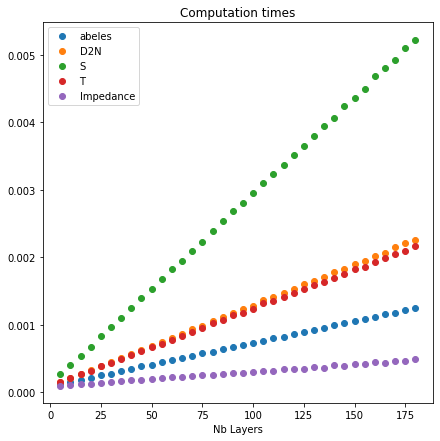

In [7]:
import matplotlib.pyplot as plt
from time import time

## Computation times

nb_iter = 100 #averaging
layers = np.arange(5, 181, 5)

wav = 3.5
ep1 = 2
ep2 = 3
materials = [1, 1.5**2, 2**2]
incidence = 15 * np.pi/180

times_s_tm = np.zeros(len(layers), dtype=float)

times_t_tm = np.zeros(len(layers), dtype=float)

times_a_tm = np.zeros(len(layers), dtype=float)

times_i_tm = np.zeros(len(layers), dtype=float)

times_dn_tm = np.zeros(len(layers), dtype=float)

for i in range(nb_iter):
    for j, nb_couches in enumerate(layers):

        ## Case 1: single layer, TE
        #structure = np.random.random(nb_couches*2+1)*w_mean
        structure = np.array([ep1, ep2]*nb_couches + [ep1])

        stack = [0]+[1,2]*nb_couches+[1,0]


        epaisseurs = np.concatenate(([0],structure,[0]))


        chose = Structure(materials,stack,epaisseurs, verbose=False)
        a = time()
        r, t, R, T = coefficient_S(chose,wav,incidence,1)
        b = time()
        times_s_tm[j] += (b-a)/nb_iter



        chose1 = Structure(materials,stack,epaisseurs, verbose=False)
        a = time()
        r_ab, t_ab, R_ab, T_ab = coefficient_A(chose1,wav,incidence,1)
        b = time()
        times_a_tm[j] += (b-a)/nb_iter


        chose1 = Structure(materials,stack,epaisseurs, verbose=False)
        a = time()
        r_t, t_t, R_t, T_t = coefficient_T(chose1,wav,incidence,1)
        b = time()
        times_t_tm[j] += (b-a)/nb_iter


        chose1 = Structure(materials,stack,epaisseurs, verbose=False)
        a = time()
        r_dn, t_dn, R_dn, T_dn = coefficient_DN(chose1,wav,incidence,1)
        b = time()
        times_dn_tm[j] += (b-a)/nb_iter


        chose1 = Structure(materials,stack,epaisseurs, verbose=False)
        a = time()
        r_i, R_i = coefficient_I(chose1,wav,incidence,1)
        b = time()
        times_i_tm[j] += (b-a)/nb_iter


plt.figure(figsize=(7,7))
plt.plot(layers, times_a_tm, 'o', label="abeles")
plt.plot(layers, times_dn_tm, 'o', label="D2N")
plt.plot(layers, times_s_tm, 'o', label="S")
plt.plot(layers, times_t_tm, 'o', label="T")
plt.plot(layers, times_i_tm, 'o', label="Impedance")
plt.title("Computation times")
plt.xlabel("Nb Layers")
plt.legend()
plt.show()

## Stability issues
However, as advertised above, these methods do not have the same stability. The most stable is the S matrix formalism, which is always correct as long as we work with real materials (permittivities and permeabilities both positive). The other methods, however, tend to accumulate errors when the number of layers increases, or when evanescent fields become important.

Intermediate incidence:


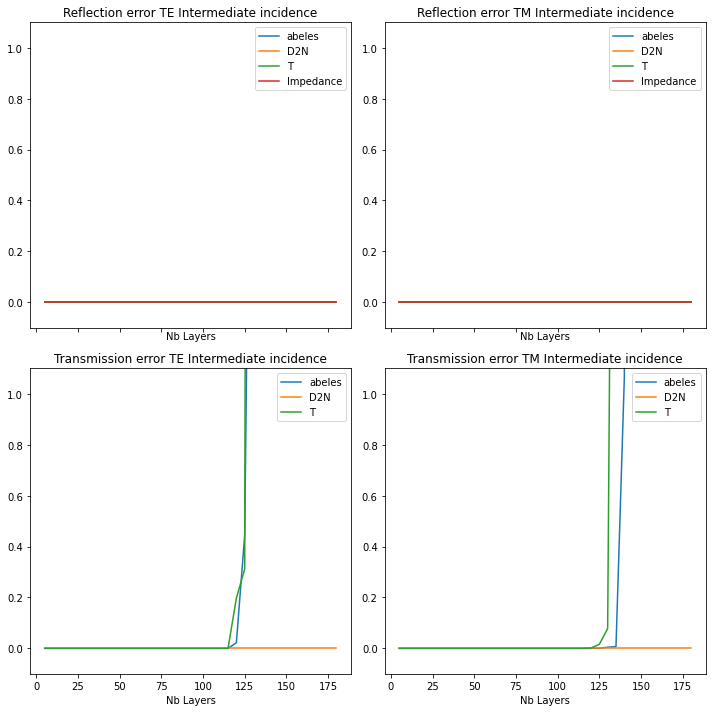

Frustrated total internal reflection:


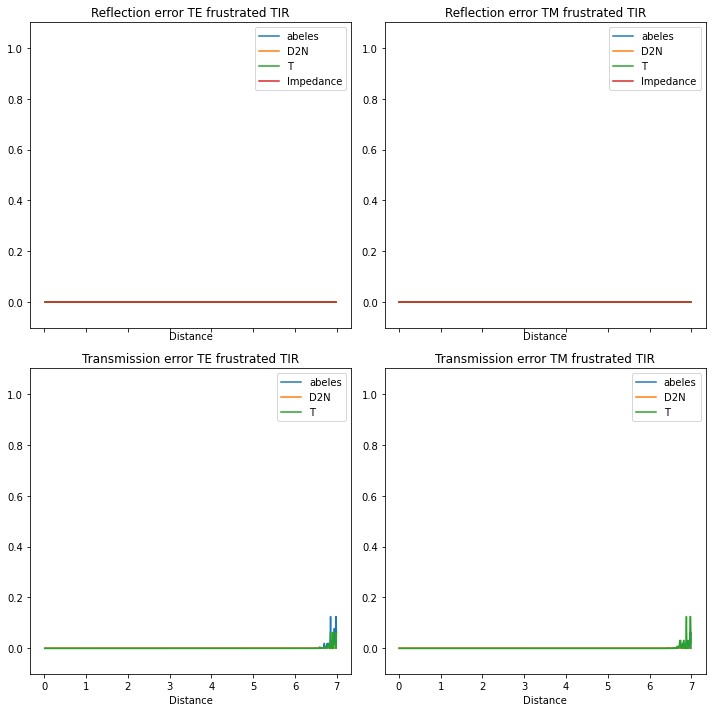

In [8]:
mat1 = 1.5
mat2 = 2


wav = 40.2

ep1 = wav/(4*mat1)
ep2 = wav/(4*mat2)

print("Intermediate incidence:")
incidence = 15*np.pi/180
materials = [1, mat1**2, mat2**2]

rs_s_te = []
ts_s_te = []

rs_t_te = []
ts_t_te = []

rs_a_te = []
ts_a_te = []

rs_i_te = []

rs_dn_te = []
ts_dn_te = []

rs_s_tm = []
ts_s_tm = []

rs_t_tm = []
ts_t_tm = []

rs_a_tm = []
ts_a_tm = []

rs_i_tm = []

rs_dn_tm = []
ts_dn_tm = []

for nb_couches in layers:

    ## Case 1: single layer, TE
    #structure = np.random.random(nb_couches*2+1)*w_mean
    structure = np.array([ep1, ep2]*nb_couches + [ep1])

    stack = [0]+[1,2]*nb_couches+[1,0]


    epaisseurs = np.concatenate(([0],structure,[0]))
    chose = Structure(materials,stack,epaisseurs, verbose=False)
    a = time()
    r, t, R, T = coefficient_S(chose,wav,incidence,0)
    b = time()
    rs_s_te.append(R)
    ts_s_te.append(T)


    r_ab, t_ab, R_ab, T_ab = coefficient_A(chose,wav,incidence,0)
    rs_a_te.append(R_ab)
    ts_a_te.append(T_ab)


    r_t, t_t, R_t, T_t = coefficient_T(chose,wav,incidence,0)
    rs_t_te.append(R_t)
    ts_t_te.append(T_t)

    r_dn, t_dn, R_dn, T_dn = coefficient_DN(chose,wav,incidence,0)
    rs_dn_te.append(R_dn)
    ts_dn_te.append(T_dn)


    r_i, R_i = coefficient_I(chose,wav,incidence,0)
    rs_i_te.append(R_i)


    r, t, R, T = coefficient_S(chose,wav,incidence,1)
    rs_s_tm.append(R)
    ts_s_tm.append(T)



    r_ab, t_ab, R_ab, T_ab = coefficient_A(chose,wav,incidence,1)
    rs_a_tm.append(R_ab)
    ts_a_tm.append(T_ab)


    r_t, t_t, R_t, T_t = coefficient_T(chose,wav,incidence,1)
    rs_t_tm.append(R_t)
    ts_t_tm.append(T_t)


    r_dn, t_dn, R_dn, T_dn = coefficient_DN(chose,wav,incidence,1)
    rs_dn_tm.append(R_dn)
    ts_dn_tm.append(T_dn)


    r_i, R_i = coefficient_I(chose,wav,incidence,1)
    rs_i_tm.append(R_i)

rs_a_te = np.array(rs_a_te)
rs_a_tm = np.array(rs_a_tm)
ts_a_te = np.array(ts_a_te)
ts_a_tm = np.array(ts_a_tm)

rs_s_te = np.array(rs_s_te)
rs_s_tm = np.array(rs_s_tm)
ts_s_te = np.array(ts_s_te)
ts_s_tm = np.array(ts_s_tm)

rs_t_te = np.array(rs_t_te)
rs_t_tm = np.array(rs_t_tm)
ts_t_te = np.array(ts_t_te)
ts_t_tm = np.array(ts_t_tm)

rs_dn_te = np.array(rs_dn_te)
rs_dn_tm = np.array(rs_dn_tm)
ts_dn_te = np.array(ts_dn_te)
ts_dn_tm = np.array(ts_dn_tm)

rs_i_te = np.array(rs_i_te)
rs_i_tm = np.array(rs_i_tm)

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10,10))
axs[0,0].plot(layers, abs(rs_s_te-rs_a_te), label="abeles")
axs[0,0].plot(layers, abs(rs_s_te-rs_dn_te), label="D2N")
axs[0,0].plot(layers, abs(rs_s_te-rs_t_te), label="T")
axs[0,0].plot(layers, abs(rs_s_te-rs_i_te), label="Impedance")
axs[0,0].set_title("Reflection error TE Intermediate incidence")
axs[0,0].set_xlabel("Nb Layers")
axs[0,0].set_ylim([-0.1,1.1])
axs[0,0].legend()


axs[0,1].plot(layers, abs(rs_s_tm-rs_a_tm), label="abeles")
axs[0,1].plot(layers, abs(rs_s_tm-rs_dn_tm), label="D2N")
axs[0,1].plot(layers, abs(rs_s_tm-rs_t_tm), label="T")
axs[0,1].plot(layers, abs(rs_s_tm-rs_i_tm), label="Impedance")
axs[0,1].set_title("Reflection error TM Intermediate incidence")
axs[0,1].set_xlabel("Nb Layers")
axs[0,1].set_ylim([-0.1,1.1])
axs[0,1].legend()


axs[1,0].plot(layers, abs(ts_s_te-ts_a_te), label="abeles")
axs[1,0].plot(layers, abs(ts_s_te-ts_dn_te), label="D2N")
axs[1,0].plot(layers, abs(ts_s_te-ts_t_te), label="T")
axs[1,0].set_title("Transmission error TE Intermediate incidence")
axs[1,0].set_xlabel("Nb Layers")
axs[1,0].set_ylim([-0.1,1.1])
axs[1,0].legend()


axs[1,1].plot(layers, abs(ts_s_tm-ts_a_tm), label="abeles")
axs[1,1].plot(layers, abs(ts_s_tm-ts_dn_tm), label="D2N")
axs[1,1].plot(layers, abs(ts_s_tm-ts_t_tm), label="T")
axs[1,1].set_title("Transmission error TM Intermediate incidence")
axs[1,1].set_xlabel("Nb Layers")
axs[1,1].set_ylim([-0.1,1.1])
axs[1,1].legend()


plt.tight_layout()
plt.show()

## Frustrated total internal reflection


print("Frustrated total internal reflection:")
materials = [1, mat1**2, mat2**2]

incidence = np.arcsin(1/mat1)+0.3

stack = [1, 0, 1]

distances = wav * np.arange(0.01, 7, 0.01)

rs_s_te = []
ts_s_te = []

rs_t_te = []
ts_t_te = []

rs_a_te = []
ts_a_te = []

rs_i_te = []

rs_dn_te = []
ts_dn_te = []

rs_s_tm = []
ts_s_tm = []

rs_t_tm = []
ts_t_tm = []

rs_a_tm = []
ts_a_tm = []

rs_i_tm = []

rs_dn_tm = []
ts_dn_tm = []

for dist in distances:

    ## Case 1: single layer, TE

    epaisseurs = np.concatenate(([0],[dist],[0]))
    chose = Structure(materials,stack,epaisseurs, verbose=False)
    r, t, R, T = coefficient_S(chose,wav,incidence,0)
    rs_s_te.append(R)
    ts_s_te.append(T)


    r_ab, t_ab, R_ab, T_ab = coefficient_A(chose,wav,incidence,0)
    rs_a_te.append(R_ab)
    ts_a_te.append(T_ab)


    r_t, t_t, R_t, T_t = coefficient_T(chose,wav,incidence,0)
    rs_t_te.append(R_t)
    ts_t_te.append(T_t)


    r_dn, t_dn, R_dn, T_dn = coefficient_DN(chose,wav,incidence,0)
    rs_dn_te.append(R_dn)
    ts_dn_te.append(T_dn)


    r_i, R_i = coefficient_I(chose,wav,incidence,0)
    rs_i_te.append(R_i)


    r, t, R, T = coefficient_S(chose,wav,incidence,1)
    rs_s_tm.append(R)
    ts_s_tm.append(T)



    r_ab, t_ab, R_ab, T_ab = coefficient_A(chose,wav,incidence,1)
    rs_a_tm.append(R_ab)
    ts_a_tm.append(T_ab)


    r_t, t_t, R_t, T_t = coefficient_T(chose,wav,incidence,1)
    rs_t_tm.append(R_t)
    ts_t_tm.append(T_t)


    r_dn, t_dn, R_dn, T_dn = coefficient_DN(chose,wav,incidence,1)
    rs_dn_tm.append(R_dn)
    ts_dn_tm.append(T_dn)


    r_i, R_i = coefficient_I(chose,wav,incidence,1)
    rs_i_tm.append(R_i)

rs_a_te = np.array(rs_a_te)
rs_a_tm = np.array(rs_a_tm)
ts_a_te = np.array(ts_a_te)
ts_a_tm = np.array(ts_a_tm)

rs_s_te = np.array(rs_s_te)
rs_s_tm = np.array(rs_s_tm)
ts_s_te = np.array(ts_s_te)
ts_s_tm = np.array(ts_s_tm)

rs_t_te = np.array(rs_t_te)
rs_t_tm = np.array(rs_t_tm)
ts_t_te = np.array(ts_t_te)
ts_t_tm = np.array(ts_t_tm)

rs_dn_te = np.array(rs_dn_te)
rs_dn_tm = np.array(rs_dn_tm)
ts_dn_te = np.array(ts_dn_te)
ts_dn_tm = np.array(ts_dn_tm)

rs_i_te = np.array(rs_i_te)
rs_i_tm = np.array(rs_i_tm)

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10,10))
axs[0,0].plot(distances/wav, abs(rs_s_te-rs_a_te), label="abeles")
axs[0,0].plot(distances/wav, abs(rs_s_te-rs_dn_te), label="D2N")
axs[0,0].plot(distances/wav, abs(rs_s_te-rs_t_te), label="T")
axs[0,0].plot(distances/wav, abs(rs_s_te-rs_i_te), label="Impedance")
axs[0,0].set_title("Reflection error TE frustrated TIR")
axs[0,0].set_xlabel("Distance")
axs[0,0].set_ylim([-0.1,1.1])
axs[0,0].legend()


axs[0,1].plot(distances/wav, abs(rs_s_tm-rs_a_tm), label="abeles")
axs[0,1].plot(distances/wav, abs(rs_s_tm-rs_dn_tm), label="D2N")
axs[0,1].plot(distances/wav, abs(rs_s_tm-rs_t_tm), label="T")
axs[0,1].plot(distances/wav, abs(rs_s_tm-rs_i_tm), label="Impedance")
axs[0,1].set_title("Reflection error TM frustrated TIR")
axs[0,1].set_xlabel("Distance")
axs[0,1].set_ylim([-0.1,1.1])
axs[0,1].legend()


axs[1,0].plot(distances/wav, abs(ts_s_te-ts_a_te), label="abeles")
axs[1,0].plot(distances/wav, abs(ts_s_te-ts_dn_te), label="D2N")
axs[1,0].plot(distances/wav, abs(ts_s_te-ts_t_te), label="T")
axs[1,0].set_title("Transmission error TE frustrated TIR")
axs[1,0].set_xlabel("Distance")
axs[1,0].set_ylim([-0.1,1.1])
axs[1,0].legend()


axs[1,1].plot(distances/wav, abs(ts_s_tm-ts_a_tm), label="abeles")
axs[1,1].plot(distances/wav, abs(ts_s_tm-ts_dn_tm), label="D2N")
axs[1,1].plot(distances/wav, abs(ts_s_tm-ts_t_tm), label="T")
axs[1,1].set_title("Transmission error TM frustrated TIR")
axs[1,1].set_xlabel("Distance")
axs[1,1].set_ylim([-0.1,1.1])
axs[1,1].legend()


plt.tight_layout()
plt.show()

As we can see, when the number of layers increases, the T matrix and Abeles formalisms no longer compute reliably the transmission coefficients.

Also, in the case of frustrated total internal reflection, these methods also present ~10% error in the transmission coefficient.

On the other hand, quite impressively, the Impedance formalism and D2N formalism remain vary reliable, with no significant difference with the S matrix formalism.